## Outline for A/B Tests
[source of tutorial](https://towardsdatascience.com/the-math-behind-a-b-testing-with-example-code-part-1-of-2-7be752e1d06f)
1. Set up the experiment
2. Run the test and record the success rate for each group
3. Plot the distribution of the difference between the two samples
4. Calculate the statistical power
5. Evaluate how sample size affects A/B tests

Additional resources
   * [Optimizely's Glossary](https://www.optimizely.com/optimization-glossary/)
   * [Evan Miller's A/B Testing Articles](http://www.evanmiller.org/)
   * [Facebook's Help Webpage on Ads Measurement](https://www.facebook.com/business/help/927019534094639/?helpref=hc_fnav&bc[0]=AHCv1&bc[1]=Ads%20Help&bc[2]=Measure%20%26%20Optimize)
   

## Baseline Conversion Rate and Lift
**baseline conversion rate**: is the current rate at which we sign up new users under the existing design <br>
**desired lift**: a 5% increase in our sign up rate

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')


np.random.seed(seed = 28)
p_A = 0.10  # baseline conversion rate
p_B = 0.15  # difference between the groups

## Control Group (A) and Test Group (B)
Typically, the total number of users participating in the A/B test make up a small percentage of the total amount of users. Users are randomly selected and assigned to either a control group or a test group. The sample size that you decide on will determine how long you might have to wait until you have collected enough.

Lets try with 1000 for A and 1000 for B

In [2]:
N_A = 1000 # Control
N_B = 1000 # Test

## Get data and run test

In [3]:
import scipy.stats as scs
import pandas as pd
# import numpy as np

def generate_data(N_A, N_B, p_A, p_B, days=None, control_label='A',
                  test_label='B'):
    """Returns a pandas dataframe with fake CTR data
    Example:
    Parameters:
        N_A (int): sample size for control group
        N_B (int): sample size for test group
            Note: final sample size may not match N_A provided because the
            group at each row is chosen at random (50/50).
        p_A (float): conversion rate; conversion rate of control group
        p_B (float): conversion rate; conversion rate of test group
        days (int): optional; if provided, a column for 'ts' will be included
            to divide the data in chunks of time
            Note: overflow data will be included in an extra day
        control_label (str)
        test_label (str)
    Returns:
        df (df)
    """

    # initiate empty container
    data = []

    # total amount of rows in the data
    N = N_A + N_B

    group_bern = scs.bernoulli(0.5)

    # initiate bernoulli distributions to randomly sample from
    A_bern = scs.bernoulli(p_A)
    B_bern = scs.bernoulli(p_B)

    for idx in range(N):
        # initite empty row
        row = {}
        # for 'ts' column
        if days is not None:
            if type(days) == int:
                row['ts'] = idx // (N // days)
            else:
                raise ValueError("Provide an integer for the days parameter.")
        # assign group based on 50/50 probability
        row['group'] = group_bern.rvs()

        if row['group'] == 0:
            # assign conversion based on provided parameters
            row['converted'] = A_bern.rvs()
        else:
            row['converted'] = B_bern.rvs()
        # collect row into data container
        data.append(row)

    # convert data into pandas dataframe
    df = pd.DataFrame(data)

    # transform group labels of 0s and 1s to user-defined group labels
    df['group'] = df['group'].apply(
        lambda x: control_label if x == 0 else test_label)

    return df

In [4]:
ab_data = generate_data(N_A, N_B, p_A, p_B)
ab_data.shape

(2000, 2)

In [5]:
ab_data.head()

,converted,group
0,0,B
1,0,A
2,0,B
3,0,A
4,1,B


let's see how many users from each group converted.

In [6]:
A_group = ab_data[ab_data['group'] == 'A']
B_group = ab_data[ab_data['group'] == 'B']

In [7]:
A_converted, B_converted = A_group['converted'].sum(), B_group['converted'].sum()
A_converted, B_converted

(116, 150)

In [8]:
A_total, B_total = len(A_group), len(B_group)
A_total, B_total

(1036, 964)

In [9]:
p_A, p_B = A_converted / A_total, B_converted / B_total
p_A, p_B

(0.11196911196911197, 0.15560165975103735)

In [10]:
p_B - p_A

0.04363254778192538

In [11]:
ab_summary = ab_data.pivot_table(values = 'converted', index='group',aggfunc=np.sum)
ab_summary['total'] = ab_data.pivot_table(values = 'converted', index='group',aggfunc=lambda x: len(x))
ab_summary['rate'] = ab_data.pivot_table(values = 'converted', index='group')

In [12]:
ab_summary

,converted,total,rate
group,,,
A,116,1036,0.111969
B,150,964,0.155602


Looks like the conversion between the 2 groups are 0.014. **This is a good sign but this is not enough evidence for us to confidently go with the new design**. At this point we have not measured how confident we are in this result.

## Compare the 2 groups
We can compare the two groups by plotting the distribution of the control group and calculating the probability of getting the result from our test group. We can assume that the distribution for our control group is binomial because the data is a series of Bernoulli trials, where each trial only has two possible outcomes (similar to a coin flip).

Text(0, 0.5, 'probability')

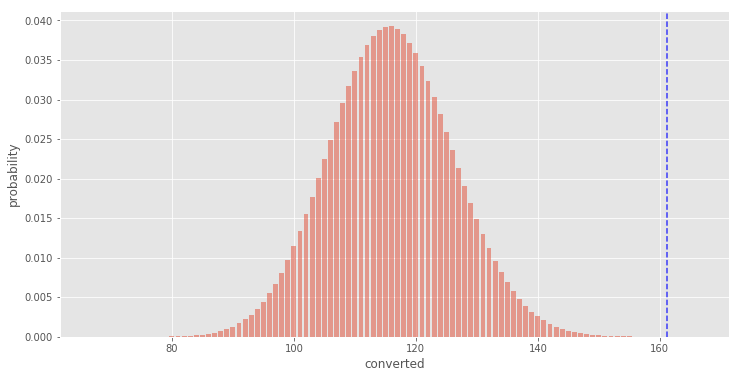

In [13]:
fig, ax = plt.subplots(figsize=(12,6))
x = np.linspace(A_converted - 49, A_converted + 50, 100)
y = scs.binom(A_total, p_A).pmf(x) #why x in pmf?
ax.bar(x,y,alpha=0.5)
ax.axvline(x=p_B * A_total, c= 'blue', alpha=0.75, linestyle='--')
plt.xlabel('converted')
plt.ylabel('probability')

The distribution for the control group is shown in red and the result from the test group is indicated by the blue dashed line. We can see that the probability of getting the result from the test group was very low. **However, the probability does not convey the confidence level of the results.** It does not take the sample size of our test group into consideration. Intuitively, we would feel more confident in our results as our sample sizes grow larger. Let’s continue and plot the test group results as a binomial distribution and compare the distributions against each other.

### Lets plot both control and test group as binomial distributions

Text(0, 0.5, 'probability')

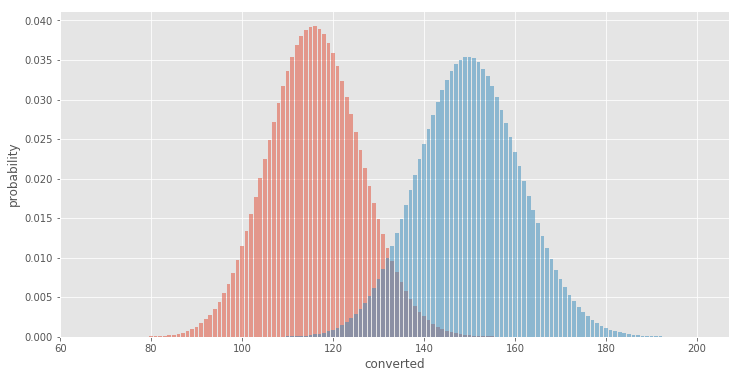

In [14]:
fig, ax = plt.subplots(figsize=(12,6))
xA = np.linspace(A_converted-49, A_converted+50, 100)
yA = scs.binom(A_total,p_A).pmf(xA)
ax.bar(xA, yA, alpha=.5)

xB = np.linspace(B_converted-49, B_converted+50, 100)
yB = scs.binom(B_total,p_B).pmf(xB)
ax.bar(xB, yB, alpha=.5)
plt.xlabel('converted')
plt.ylabel('probability')

We can see that the test group converted more users than the control group. We can also see that the peak of the test group results is lower than the control group. How do we interpret the difference in peak probability? We should focus instead on the conversion rate so that we have an apples-to-apples comparison. In order to calculate this, we need to standardize the data and compare the probability of successes, $p$, for each group.

## Lets talk about Bernoulli distribution

$$ X \sim Bernoulli(p) $$
where p is the true conversion probability of the control group.

The mean and variance of Bernoulli distribution is:
$$ E(X) = p $$

$$ Var(X) = p(1-p) $$

According to the *central limit theorem*, by calculating many sample means we can approximate the true mean of the population, 𝜇, from which the data for the control group was taken. The distribution of the sample means, $p$, will be normally distributed around the true mean with a standard deviation equal to the standard error of the mean

$$ \sigma_{\bar{x}} = \frac{s}{\sqrt{n}} = \frac{\sqrt{p(1-p)}}{\sqrt{n}} $$

Therefore we can rewrite the equation as

$$ \hat{p} \sim Normal\left(\mu = p, \: \sigma = \frac{\sqrt{p(1-p)}}{\sqrt{n}}\right) $$

### Lets plot the standard error of the mean
Since the distribution of the sample means will be normally distributed around the true mean with a standard deviation equal to the standard error of the mean, lets use the standard error as the standard deviation

Text(0, 0.5, 'PDF')

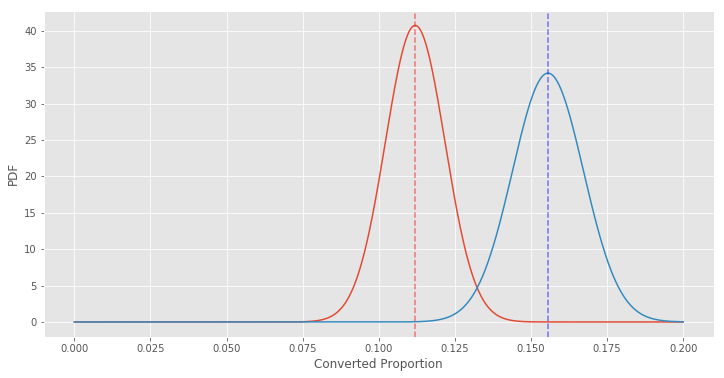

In [15]:
# standard error of the mean for both groups
SE_A = np.sqrt(p_A * (1-p_A)) / np.sqrt(A_total)
SE_B = np.sqrt(p_B * (1-p_B)) / np.sqrt(B_total)

# plot the null and alternate hypothesis
fig, ax = plt.subplots(figsize=(12,6))

xA = np.linspace(0,.2,1000)
yA = scs.norm(p_A, SE_A).pdf(xA) #normal distribution and using standard error of the mean as standard deviation
ax.plot(xA,yA)
ax.axvline(x=p_A, c='red', alpha=.5, linestyle='--')

xB = np.linspace(0,.2,1000)
yB = scs.norm(p_B, SE_B).pdf(xB)
ax.plot(xB, yB)
ax.axvline(x=p_B, c='blue', alpha=.5, linestyle='--')

plt.xlabel('Converted Proportion')
plt.ylabel('PDF')

The dashed lines represent the mean conversion rate for each group. The distance between the red dashed line and the blue dashed line is equal to mean difference between the control and test group.

$$\hat{d} = \hat{p}_B - \hat{p}_A$$

## Variance of the Sum
Recall that the null hypothesis states that the difference in probability between the two groups is zero. Therefore, the mean for this normal distribution will be at zero. The other property we will need for the normal distribution is the standard deviation or the variance. (Note: The variance is the standard deviation squared.)

A basic property of variance is that the variance of the sum of two random independent variables is the sum of the variances.

$$Var(X + Y) = Var(X) + Var(Y)$$
$$Var(X - Y) = Var(X) + Var(Y)$$

Which means that the **null hypothesis and alternate hypothesis will have the same variance** which will be the sum of the variances for the control group and the test group.

$$Var(\hat{d}) = Var(\hat{p}_B - \hat{p}_A) = Var(\hat{p}_A) + Var(\hat{p}_B) = \frac{p_A(1 - p_A)}{n_A} + \frac{p_B(1 - p_B)}{n_B}$$

So... the standard deviation would just be 

$$\sigma = \sqrt{Var(\hat{d})}= \sqrt{ \frac{p_A(1-p_A)}{n_A} + \frac{p_B(1-p_B)}{n_B} }$$

## Pooled Variance

We can put this equation in terms of $s$, because $s$ is the standard deviation of the Bernoulli distribution.

$$ \sigma = \sqrt{Var(\hat{d})} = \sqrt{ \frac{s_A^2}{n_A} + \frac{s_B^2}{n_B} } $$

## Compare the Null Hypothesis vs the Alternate Hypothesis
* The null hypothesis is the position that the change in the design made for the test group would result in no change in the conversion rate
* The alternative hypothesis is the opposing position that the change in the design for the test group would result in an improvement (or reduction) in the conversion rate

The null hypothesis will be a **normal distribution with a mean of zero** and a **standard deviation equal to the pooled standard error**.<br>
**The null hypothesis**
$$H_0 : d = 0$$ 
$$\hat{d}_o \sim Normal(0, SE_pool)$$

The alternative hypothesis has the same standard deviation as the null hypothesis, but the mean will be located at the difference in the conversion rate, d_hat. This makes sense because we can calculate the difference in the conversion rates directly from the data, but the normal distribution represents the possible values our experiment could have given us.

**The alternate hypothesis**
$$H_0 : d = p_B - p_A$$ 
$$\hat{d}_A \sim Normal(d, SE_pool)$$


Lets plot the null and alternative hypotheses for future experiments, using abplot.



In [16]:
def pooled_prob(N_A, N_B, X_A, X_B):
    """Returns pooled probability for two samples"""
    return (X_A + X_B) / (N_A + N_B)

def pooled_SE(N_A, N_B, X_A, X_B):
    """Returns the pooled standard error for two samples"""
    p_hat = pooled_prob(N_A, N_B, X_A, X_B)
    SE = np.sqrt(p_hat * (1 - p_hat) * (1 / N_A + 1 / N_B))
    return SE

def confidence_interval(sample_mean=0, sample_std=1, sample_size=1,
                        sig_level=0.05):
    """Returns the confidence interval as a tuple"""
    z = z_val(sig_level)

    left = sample_mean - z * sample_std / np.sqrt(sample_size)
    right = sample_mean + z * sample_std / np.sqrt(sample_size)

    return (left, right)

def plot_null(ax, stderr):
    """Plots the null hypothesis distribution where if there is no real change,
    the distribution of the differences between the test and the control groups
    will be normally distributed.

    The confidence band is also plotted.

    Example:
        plot_null(ax, stderr)

    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group

    Returns:
        None: the function adds a plot to the axes object provided

    """
    plot_norm_dist(ax, 0, stderr, label="Null")
    plot_CI(ax, mu=0, s=stderr, sig_level=0.05)
    
def plot_alt(ax, stderr, d_hat):
    """Plots the alternative hypothesis distribution where if there is a real
    change, the distribution of the differences between the test and the
    control groups will be normally distributed and centered around d_hat

    The confidence band is also plotted.

    Example:
        plot_alt(ax, stderr, d_hat=0.025)

    Parameters:
        ax (matplotlib axes)
        stderr (float): the pooled standard error of the control and test group

    Returns:
        None: the function adds a plot to the axes object provided
    """
    plot_norm_dist(ax, d_hat, stderr, label="Alternative")
    # plot_CI(ax, mu=d_hat, s=stderr, sig_level=0.05)
    
def plot_norm_dist(ax, mu, sig, with_CI=False, sig_level=0.05, label=None):
    """Adds a normal distribution to the axes provided

    Example:
        plot_norm_dist(ax, 0, 1)  # plots a standard normal distribution

    Parameters:
        ax (matplotlib axes)
        mu (float): mean of the normal distribution
        sig (float): standard deviation of the normal distribution

    Returns:
        None: the function adds a plot to the axes object provided
    """
    x = np.linspace(mu - 12 * sig, mu + 12 * sig, 1000)
    y = scs.norm(mu, sig).pdf(x)
    ax.plot(x, y, label=label)

    if with_CI:
        plot_CI(ax, mu, sig, sig_level=sig_level)   
        
def plot_CI(ax, mu, s, sig_level=0.05, color='grey'):
    """Calculates the two-tailed confidence interval and adds the plot to
    an axes object.

    Example:
        plot_CI(ax, mu=0, s=stderr, sig_level=0.05)

    Parameters:
        ax (matplotlib axes)
        mu (float): mean
        s (float): standard deviation

    Returns:
        None: the function adds a plot to the axes object provided
    """
    # z = scs.norm().ppf(1 - sig_level/2)
    # left = mu - z * s
    # right = mu + z * s
    left, right = confidence_interval(sample_mean=mu, sample_std=s,
                                      sig_level=sig_level)
    ax.axvline(left, c=color, linestyle='--', alpha=0.5)
    ax.axvline(right, c=color, linestyle='--', alpha=0.5)
    
def z_val(sig_level=0.05, two_tailed=True):
    """Returns the z value for a given significance level"""
    z_dist = scs.norm()
    if two_tailed:
        sig_level = sig_level/2
        area = 1 - sig_level
    else:
        area = 1 - sig_level

    z = z_dist.ppf(area)

    return z

def ab_dist(stderr, d_hat=0, group_type='control'):
    """Returns a distribution object depending on group type

    Examples:

    Parameters:
        stderr (float): pooled standard error of two independent samples
        d_hat (float): the mean difference between two independent samples
        group_type (string): 'control' and 'test' are supported

    Returns:
        dist (scipy.stats distribution object)
    """
    if group_type == 'control':
        sample_mean = 0

    elif group_type == 'test':
        sample_mean = d_hat

    # create a normal distribution which is dependent on mean and std dev
    dist = scs.norm(sample_mean, stderr)
    return dist

In [17]:
def show_area(ax, d_hat, stderr, sig_level, area_type='power'):
    """Fill between upper significance boundary and distribution for
    alternative hypothesis
    """
    left, right = confidence_interval(sample_mean=0, sample_std=stderr,
                                      sig_level=sig_level)
    x = np.linspace(-12 * stderr, 12 * stderr, 1000)
    null = ab_dist(stderr, 'control')
    alternative = ab_dist(stderr, d_hat, 'test')

    # if area_type is power
    # Fill between upper significance boundary and distribution for alternative
    # hypothesis
    if area_type == 'power':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'power = {0:.3f}'.format(1 - alternative.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is alpha
    # Fill between upper significance boundary and distribution for null
    # hypothesis
    if area_type == 'alpha':
        ax.fill_between(x, 0, null.pdf(x), color='green', alpha='0.25',
                        where=(x > right))
        ax.text(-3 * stderr, null.pdf(0),
                'alpha = {0:.3f}'.format(1 - null.cdf(right)),
                fontsize=12, ha='right', color='k')

    # if area_type is beta
    # Fill between distribution for alternative hypothesis and upper
    # significance boundary
    if area_type == 'beta':
        ax.fill_between(x, 0, alternative.pdf(x), color='green', alpha='0.25',
                        where=(x < right))
        ax.text(-3 * stderr, null.pdf(0),
                'beta = {0:.3f}'.format(alternative.cdf(right)),
                fontsize=12, ha='right', color='k')


def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test

    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03) - really??

    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.

    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-3 * d_hat, 3 * d_hat)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_val = p_value(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_val),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

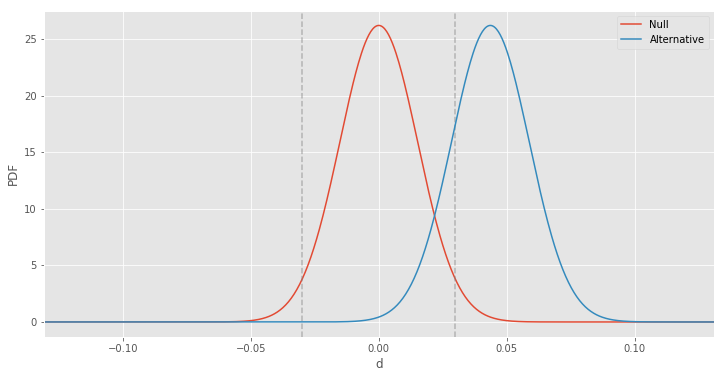

In [18]:
# define the parameters for abplot()
# use the actual values from the experiment for bcr and d_hat
# p_A is the conversion rate of the control group
# p_B is the conversion rate of the test group

n = N_A + N_B
bcr = p_A
d_hat = p_B - p_A
abplot(N_A, N_B, bcr, d_hat)

Fortunately, both curves are identical in shape, so we can just compare the distance between the means of the two distributions. We can see that the alternative hypothesis curve suggests that the test group has a higher conversion rate than the control group. This plot also can be used to directly determine the statistical power.

## Statistical Power and Significance Level
it is easier to define statistical power and significance level by first showing how they are represented in the plot of the null and alternative hypothesis. We can return a visualization of the statistical power by adding the parameter `show_power=True`

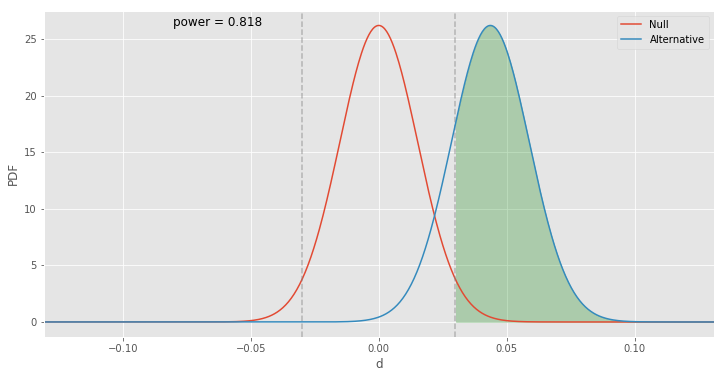

In [19]:
abplot(N_A, N_B, bcr, d_hat, show_power = True)

The green shaded area represents the *statistical power*, and the calculated value for power is also displayed on the plot. The gray dashed lines in the plot above represent the confidence interval (95% for the plot above) for the null hypothesis. Statistical power is calculated by finding the area under the alternative hypothesis distribution and outside of the confidence interval of the null hypothesis.

Just a recap, the power of hypothesis test is the probability that the test rejects the null hypothesis (H_0) when a specific alternative hypothesis (H_1) is true. The power ranges from 0 to 1 and as the power increases, the probability of making a type 2($\beta$) error decreases. For example, if experiment 1 has a statistical power of 0.7, and experiment 2 has a statistical power of 0.95, then there is a stronger probability that experiment 1 had a type II error than experiment 2, and experiment 2 is more reliable than experiment 1 due to the reduction in probability of a type II error.

$$Power = Pr(reject H_0 | H_1 is true)$$

After running our experiment, we get a resulting conversion rate for both groups. If we calculate the difference between the conversion rates, we end up with one result, the difference or the effect of the design change. Our task is to determine which population this result came from, the null hypothesis or the alternative hypothesis.

### What about Beta?
The area under the alternative hypothesis curve is equal to 1. If the alternative design is truly better, the power is the probability that we accept the alternative hypothesis and reject the null hypothesis and is equal to the area shaded green (*true positive*). The opposite area under the alternative curve is the probability that we accept the null hypothesis and reject the alternative hypothesis (*false negative*). This is referred to as *beta* in A/B testing or hypothesis testing and is shown below.

Just a recap,  *type I error* ($\alpha$)is the rejection of a true null hypothesis (also known as a "false positive" finding or conclusion), while a *type II error*($\beta$) is the failure to reject a false null hypothesis (also known as a "false negative" finding or conclusion). Usually a type I error leads one to conclude that a supposed effect or relationship exists when in fact it doesn't. Examples of type II errors would be a blood test failing to detect the disease it was designed to detect, in a patient who really has the disease.

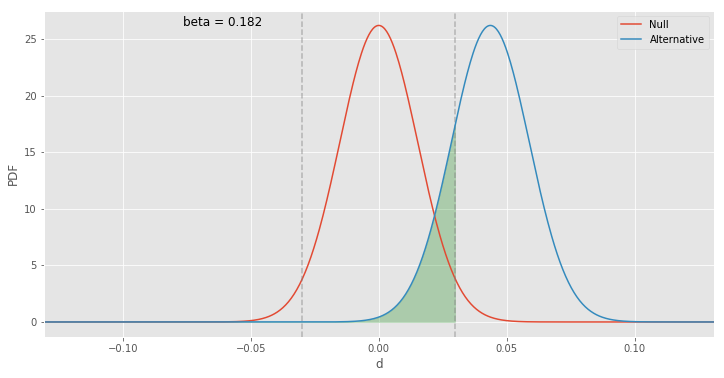

In [20]:
abplot(N_A, N_B, bcr, d_hat, show_beta=True)

The gray dashed line that divides the area under the alternative curve into two also directly segments the area associated with the significance level, often denoted with the greek letter alpha.

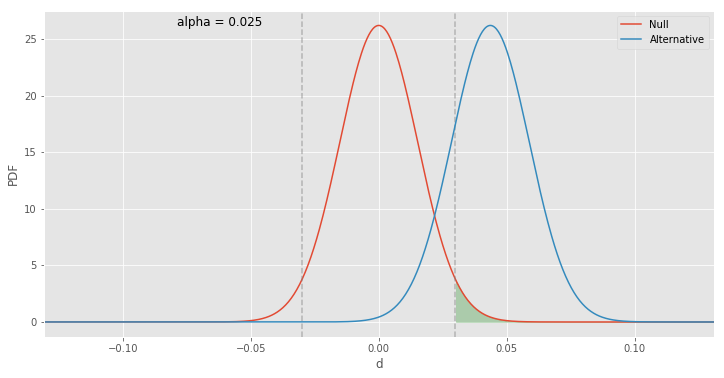

In [21]:
abplot(N_A, N_B, bcr, d_hat, show_alpha=True)

If the null hypothesis is true and there truly is no difference between the control and test groups, then the significance level is the probability that we would reject the null hypothesis and accept the alternative hypothesis (false positive). A false positive is when we mistakenly conclude that the new design is better. This value is low because we want to limit this probability.

Oftentimes, a problem will be given with a desired confidence level instead of the significance level. A typical 95% confidence level for an A/B test corresponds to a significance level of 0.05.

$\alpha$ = 100% - Confidence Level

Experiments are typically set up for a minimum desired power of 80%. If our new design is truly better, we want our experiment to show that there is at least an 80% probability that this is the case. Unfortunately, our current experiment only has a power of 0.594. We know that if we increase the sample size for each group, we will decrease the pooled variance for our null and alternative hypothesis. This will make our distributions much narrower and may increase the statistical power.

## Sample Size

If we run our test again with a sample size of 2000 instead of 1000 for each group, we get the following results.

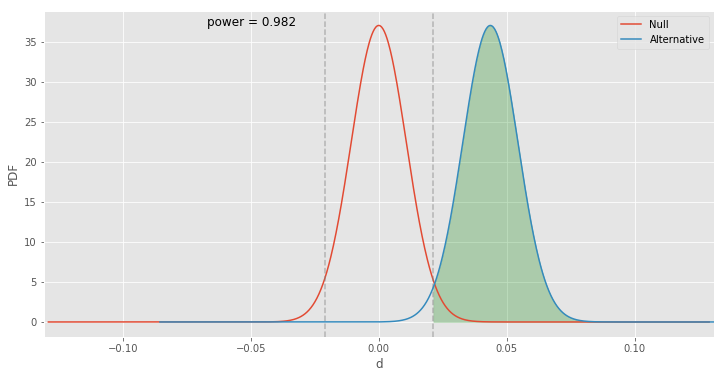

In [22]:
abplot(2000, 2000, bcr, d_hat, show_power=True)

Our curves for the null and alternative hypothesis have become more narrow and more of the area under the alternative curve is located on the right of the gray dashed line. The result for power is greater than 0.80 and meets our benchmark for statistical power. We can now say that our results are statistically significant.

A problem you may encounter is determining the minimum sample size you will need for your experiment. This is a common interview question and it is useful to know because it is directly related to how quickly you can complete your experiments and deliver statistically significant results to your design team.

[Evan's awesome A/B Tools](http://www.evanmiller.org/ab-testing/sample-size.html)
[Optimizely calculator](https://www.optimizely.com/sample-size-calculator/?conversion=10&effect=10&significance=95)

You will need the baseline conversion rate (bcr) and the minimum detectable effect, which is the minimum difference between the control and test group that you or your team will determine to be worth the investment of making the design change in the first place.

To demonstrate, let’s use an example with a 20% baseline conversion rate and a 5% MDE (minimum detectable effect). Based on these values, your experiment will be able to detect 80% of the time when a variation's underlying conversion rate is actually 19% or 21% (20%, +/- 5% × 20%). If you try to detect differences smaller than 5%, your test is considered underpowered.

### How long to run experiment for?
 total number of visitors need / avg number of visitors per day = estimated number of days to run experiment

### Minimum sample size calculator

In [23]:
def min_sample_size(bcr, mde, power=0.8, sig_level=0.05):
    """Returns the minimum sample size to set up a split test
    Arguments:
        bcr (float): probability of success for control, sometimes
        referred to as baseline conversion rate
        mde (float): minimum change in measurement between control
        group and test group if alternative hypothesis is true, sometimes
        referred to as minimum detectable effect
        power (float): probability of rejecting the null hypothesis when the
        null hypothesis is false, typically 0.8
        sig_level (float): significance level often denoted as alpha,
        typically 0.05
    Returns:
        min_N: minimum sample size (float)
    References:
        Stanford lecture on sample sizes
        http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf
    """
    # standard normal distribution to determine z-values
    standard_norm = scs.norm(0, 1)
    
    # find Z_beta from desired power
    Z_beta = standard_norm.ppf(power)

    # find Z_alpha
    Z_alpha = standard_norm.ppf(1-sig_level/2)

    # average of probabilities from both groups
    pooled_prob = (bcr + bcr+mde) / 2

    min_N = (2 * pooled_prob * (1 - pooled_prob) * (Z_beta + Z_alpha)**2
             / mde**2)

    return min_N

In [24]:
min_sample_size(bcr = 0.10, mde = 0.04)

1036.0521249340798

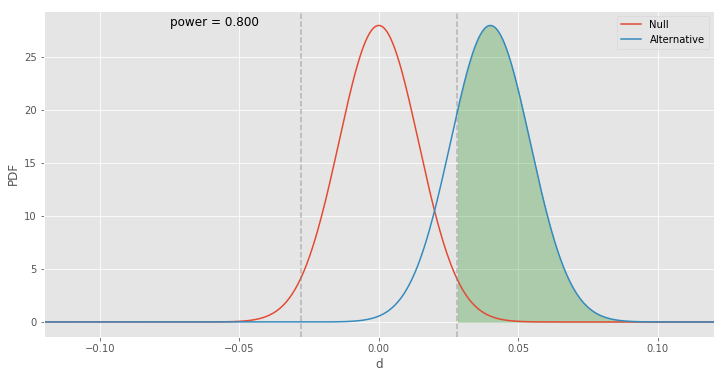

In [25]:
# see how the power returns 0.8? bingo!
abplot(1036, 1036, 0.10, 0.04, show_power=True)

### Lets play!

If i keep the number of samples to 1000 each and the minimum detectable effect to 2%, it returns a terrible power that i can't use. If i have a power of 0.298, that means i have a 0.7 probability of commiting type 2 error, which is failure to reject a false null hypothesis. This means im unable to detect the difference when there is a difference!

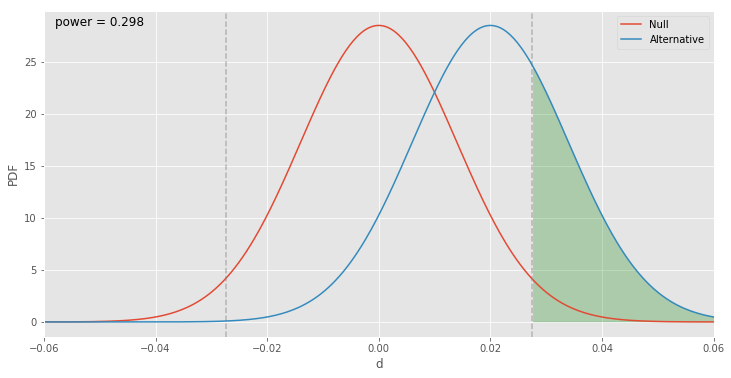

In [26]:
abplot(1000, 1000, 0.10, 0.02, show_power=True)

what i increase the sample size to 10K each and keeping MDE to 2% See how my power increased to 0.995!? Thats amazing. So the moral of the story is the smaller the MDE, the more samples you will need!

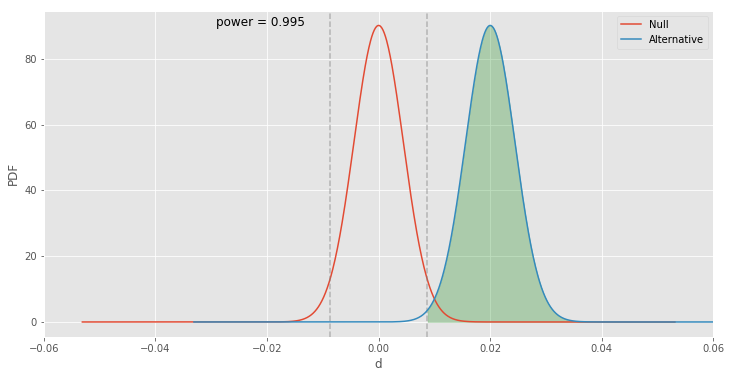

In [28]:
abplot(10000, 10000, 0.10, 0.02, show_power=True)